# Large Scale Kernel Models

In our exploration of the `kooplearn` library, we delve into the utilization of kernel methods for analyzing dynamical systems. Our initial exposure to the library, as discussed in the [getting started](getting_started) example, involved studying the behavior of the _noisy logistic map_ using the {class}`kooplearn.models.Nonlinear` class.

Expanding our investigation, we now turn our attention to two additional classes within the library: {class}`kooplearn.models.Kernel` and {class}`kooplearn.models.NystroemKernel`. These classes leverage kernel methods to effectively model the transfer operator $\mathcal{T}$. Our focus is on comparing the performance of three models implemented in the above classes:

1.   Reduced Rank Regression as described in {footcite:t}`Kostic2022`,
2.   Nyström Reduced Rank Regression as described in {footcite:t}`Meanti2023`,
3.   Randomized Reduced Rank Regression as described in {footcite:t}`Turri2023`

by investigating the Lorenz-63 System (a.k.a. Lorenz attractor). This model is defined by a system of three coupled ordinary differential equations:

$$
  \begin{align}
  \dot{x} &= \sigma (y - x), \\
  \dot{y} &= x (\rho - z) - y, \\
  \dot{z} &= x y - \beta z
  \end{align}
$$

## Setup `kooplearn` + importing dependecies

In [13]:
import importlib

for module in ['kooplearn', 'ml_confs', 'scienceplots']:
    try:
        importlib.import_module(module)
    except ImportError:
      if module == 'kooplearn':
        module = 'kooplearn[full]'
      %pip install -q {module}

In [14]:
# Import dependencies
import functools
import numpy as np
import matplotlib.pyplot as plt
import ml_confs
from tqdm.notebook import tqdm

plt.style.use(['science','sans','bright'])
plt.rcParams.update({'text.usetex' : False})

Defining the number of training and tests and a wrapper function useful for measuring the execution time of functions

In [15]:
from time import perf_counter

configs = ml_confs.from_dict({
    'train_samples': 10000,
    'test_samples': 100,
})

# Adapted from https://realpython.com/python-timer/#creating-a-python-timer-decorator
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = perf_counter()
        value = func(*args, **kwargs)
        toc = perf_counter()
        elapsed_time = toc - tic
        return value, elapsed_time

    return wrapper_timer

## Data Generation
In `kooplearn`, we provide an implementation of the Lorenz-63 system in {class}`kooplearn.datasets.Lorenz63`. With this class, we generate the dataset by setting the initial condition `X0` equal to 1 for the three components, the number of time steps `T` according to the sample sizes defined above. We left the system parameters $\sigma$, $\rho$, and $\beta$, at their default values, which are $10$, $28$ and $8/3$, respectively.

In [16]:
from kooplearn.datasets import Lorenz63

raw_data = Lorenz63().sample(X0 = np.ones(3), T=configs.train_samples + 1000 + configs.test_samples)
mean = np.mean(raw_data, axis=0)
norm = np.max(np.abs(raw_data), axis=0)
# Data rescaling
data = raw_data - mean
data /= norm

train_data = data[:configs.train_samples + 1]
test_data =  data[-configs.test_samples - 1:]

Here we provide a visualization of the sampled three-dimensional trajectory. The blue and orange lines represent the training and test trajectories, respectively.

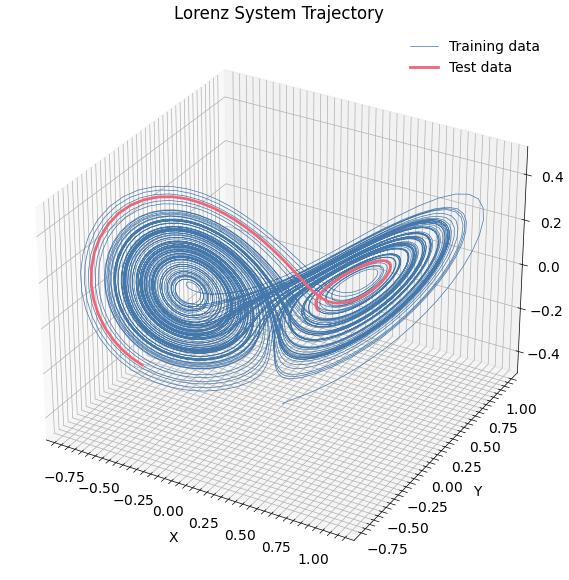

In [17]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(train_data[:,0], train_data[:,1], train_data[:,2], lw=.5, label='Training data')
ax.plot(test_data[:,0], test_data[:,1], test_data[:,2], lw=2, label='Test data')
ax.set_title("Lorenz System Trajectory")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.legend()
plt.tight_layout()
plt.show()

After having generated the trajectories, as already seen in the [getting started](getting_started) tutorial, we organize the time-series into context windows using the {meth}`kooplearn.data.traj_to_contexts` method.

In [19]:
from kooplearn.data import traj_to_contexts

# From trajectories to context windows
train_contexts = traj_to_contexts(train_data)
test_contexts = traj_to_contexts(test_data)

## Estimators fitting

Here we p we choose the RBF kernel and set its length scale using median heuristics.

In [20]:
from kooplearn.models import Kernel, NystroemKernel
from scipy.spatial.distance import pdist
from sklearn.gaussian_process.kernels import RBF

reduced_rank = True
rank = 25
num_centers = 250
tikhonov_reg = 1e-6

# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
data_pdist = pdist(train_data)
kernel = RBF(length_scale=np.quantile(data_pdist, 0.5))

In [21]:
def runner(models, stop):
    results = {}
    for name, model in models.items():
        model, fit_time = timer(model.fit)(train_contexts[:stop])
        # One-step prediction
        X_pred_train = model.predict(train_contexts)
        X_true_train = train_contexts.lookforward(model.lookback_len)
        X_pred_test = model.predict(test_contexts)
        X_true_test = test_contexts.lookforward(model.lookback_len)

        results[name] = {
            'fit_time': fit_time,
            'rMSE_onestep_train': np.sqrt(np.mean((X_pred_train - X_true_train)**2)),
            'rMSE_onestep_test': np.sqrt(np.mean((X_pred_test - X_true_test)**2)),
            # 'X_pred': X_pred
        }
        print(r'Fitting of {} model took {:.2f}s and has a test rMSE of {:.5f}.'.format(name, results[name]['fit_time'], results[name]['rMSE_onestep_test']))
    return results

In [22]:
train_stops = np.logspace(3, 4, 10).astype(int)

results = []
for stop in tqdm(train_stops, total=len(train_stops)):
    models = {
        'Kernel': Kernel(kernel=kernel, reduced_rank=reduced_rank, tikhonov_reg=tikhonov_reg, rank = rank, svd_solver='arnoldi'),
        'RandSVDKernel': Kernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='randomized', tikhonov_reg=tikhonov_reg, rank = rank, rng_seed=42),
        'Nystroem': NystroemKernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42),
    }
    print(f'\nTraining points: {stop}')
    results.append(runner(models, stop))

  0%|          | 0/1 [00:00<?, ?it/s]


Training points: 1000
Fitting of Kernel model took 0.42s and has a test rMSE of 0.00722.
Fitting of RandSVDKernel model took 0.34s and has a test rMSE of 0.00771.
Fitting of Nystroem model took 0.36s and has a test rMSE of 0.00696.


In [23]:
timings = {name: [res[name]['fit_time'] for res in results] for name in models.keys()}
train_rMSE = {name: [res[name]['rMSE_onestep_train'] for res in results] for name in models.keys()}
test_rMSE = {name: [res[name]['rMSE_onestep_test'] for res in results] for name in models.keys()}

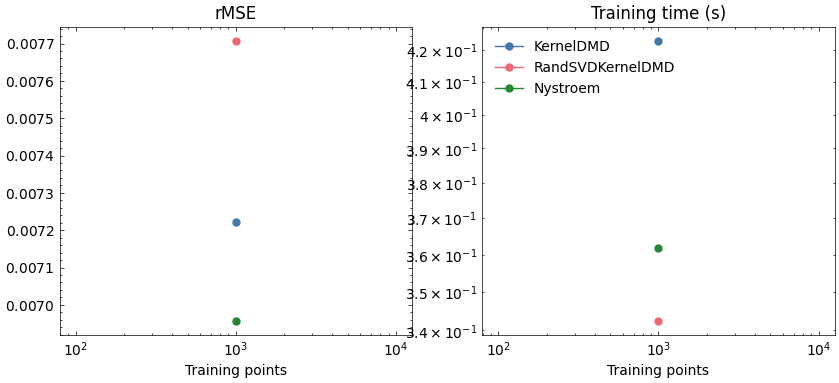

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for name in models.keys():
    axes[0].plot(train_stops, test_rMSE[name],'.-', label=name, markersize=10)
    axes[1].plot(train_stops, timings[name],'.-', label=name, markersize=10)

axes[0].set_title('rMSE')
axes[1].set_title('Training time (s)')
axes[1].legend(frameon = False, loc = 'upper left')
axes[1].set_yscale('log')
for ax in axes:
    ax.set_xscale('log')

    ax.set_xlabel('Training points')